In [6]:
import json
import os
import math
from tqdm import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "crawler", "games", "classic")

for file in tqdm(os.listdir(game_path)):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in tqdm(games):
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



100%|██████████| 24905/24905 [01:24<00:00, 295.01it/s]


Loaded 24905 games.


100%|██████████| 24905/24905 [00:00<00:00, 31547.33it/s]


Unique players: 186174


In [7]:
from analysis.core import *

In [8]:
len(get_all_participants(games))

100%|██████████| 24905/24905 [00:00<00:00, 45846.64it/s]

185854 total number of players.


185854

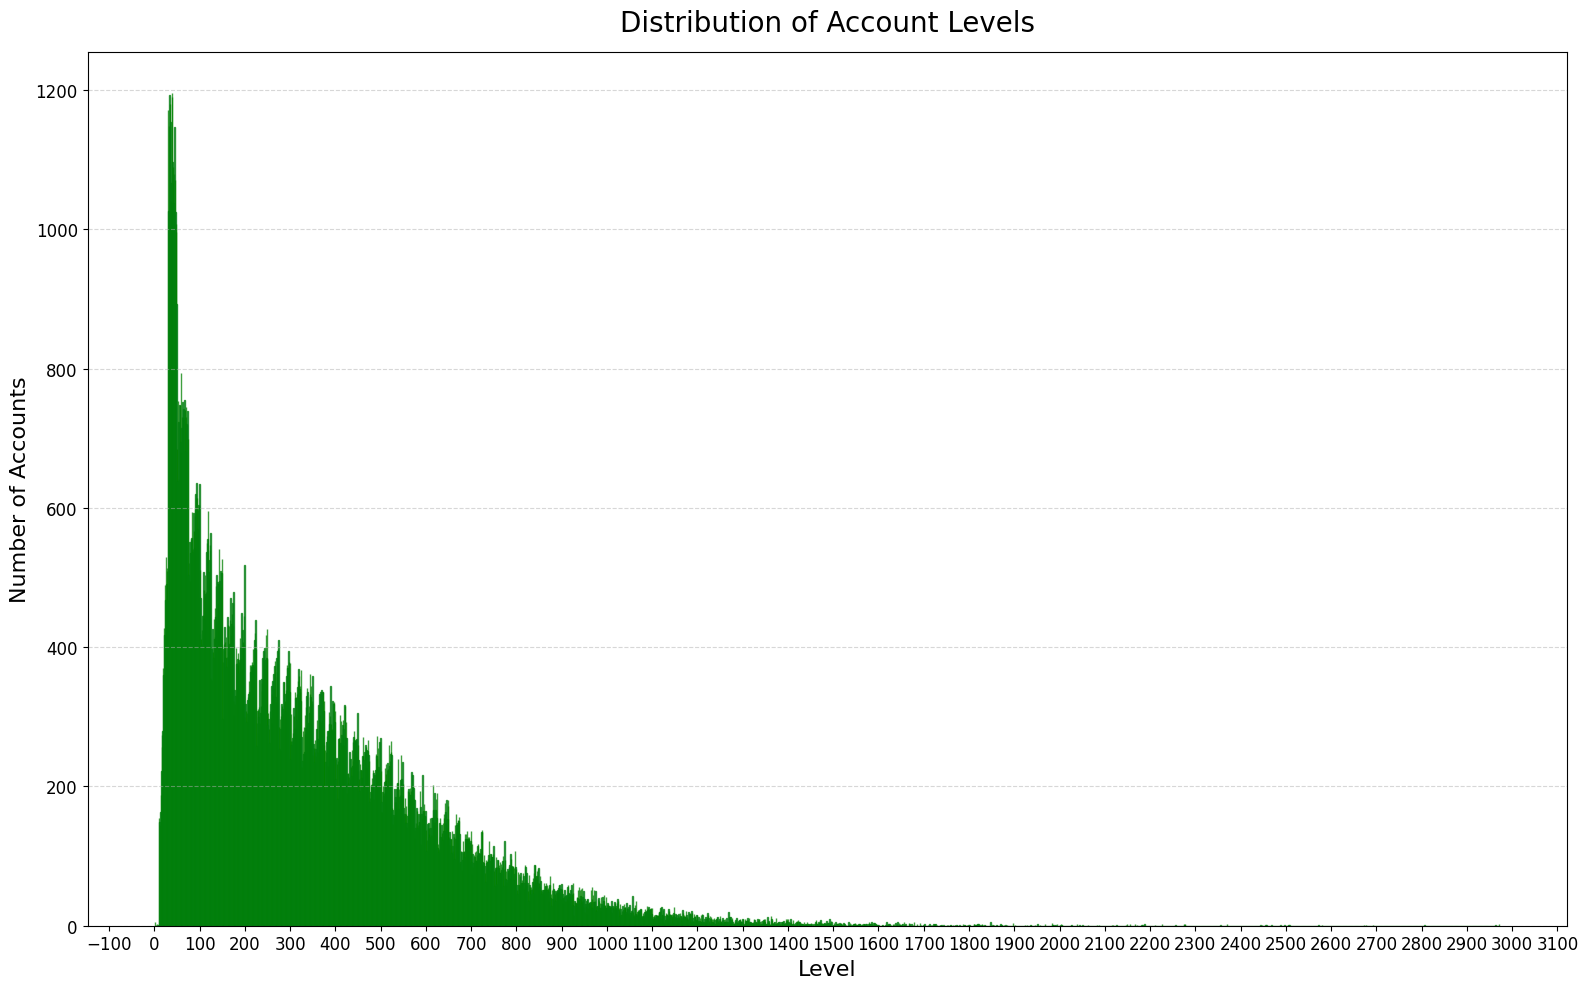

"Qnoxs #17165" Level: 2971


In [9]:
plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

100%|██████████| 61/61 [00:32<00:00,  1.85it/s]


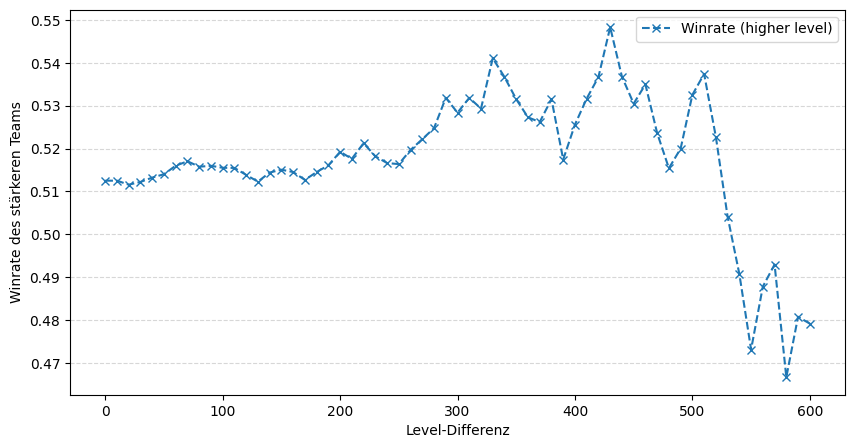

In [10]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates = [higher_level_winrate(games, d) for d in tqdm(diffs)]

plt.figure(figsize=(10, 5))
plt.plot(diffs, winrates, marker="x", linestyle="--", label="Winrate (higher level)")

#plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
#plt.yticks([i/10 for i in range(0, 11)])

plt.xlabel("Level-Differenz")
plt.ylabel("Winrate des stärkeren Teams")
plt.legend()
plt.show()


100%|██████████| 101/101 [00:57<00:00,  1.77it/s]


[0.5080800771828268, 0.5082380146178305, 0.5090353779587682, 0.5091146969036197, 0.5095126985551467, 0.5094226327944573, 0.510310996809068, 0.5105756490160475, 0.510128445956237, 0.5106617647058823, 0.5110304081522034, 0.511578357162882, 0.5104051939018028, 0.5107913669064749, 0.5114489605957183, 0.5123643137003019, 0.5125075045027017, 0.513193434448369, 0.5134030963302753, 0.5150748157522519, 0.5153435881579964, 0.5158621797445988, 0.5166847871539684, 0.5167580743449116, 0.5156066226363883, 0.5151657874905803, 0.5171498771498771, 0.5171919770773639, 0.5152936161142492, 0.5158220845319761, 0.5154449054863992, 0.5151221872731672, 0.5162025316455696, 0.5170319514127277, 0.517507582023711, 0.5202829507723401, 0.5203681351840675, 0.5221169036334913, 0.5242494226327945, 0.5235304257886572, 0.5213414634146342, 0.5211689771449981, 0.5208537301742706, 0.5209102091020911, 0.5221769873580459, 0.5201357466063349, 0.5219142383321488, 0.5213611525086935, 0.5194771241830065, 0.5199340115479791, 0.51

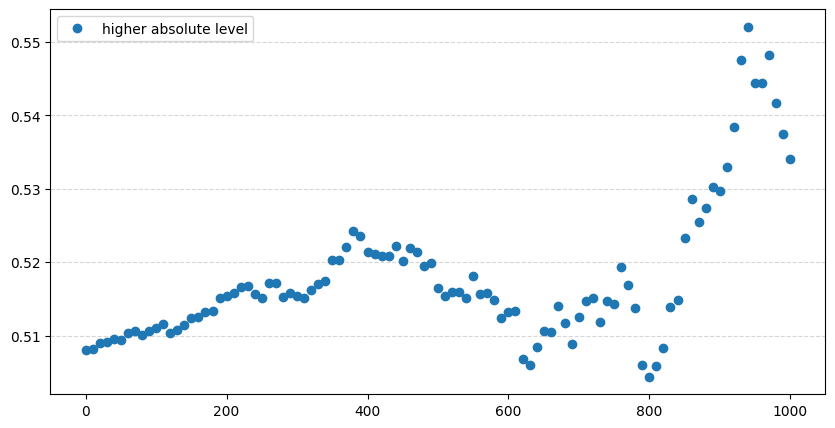

In [11]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = [higher_absolute_level_winrate(games, d) for d in tqdm(diffs)]

print(winrates_higher)
plt.figure(figsize=(10, 5))

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/100 for i in range(0, 101)])
plt.plot(diffs, winrates_higher, marker="o", linestyle="", label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
23907 Wins with higher champion level and 975 Wins with lower champion level of 24882 games
23440 Wins with higher champion level and 802 Wins with lower champion level of 24242 games
23213 Wins with higher champion level and 721 Wins with lower champion level of 23934 games
23028 Wins with higher champion level and 656 Wins with lower champion level of 23684 games
22839 Wins with higher champion level and 608 Wins with lower champion level of 23447 games
22634 Wins with higher champion level and 546 Wins with lower champion level of 23180 games
22399 Wins with higher champion level and 487 Wins with lower champion lev

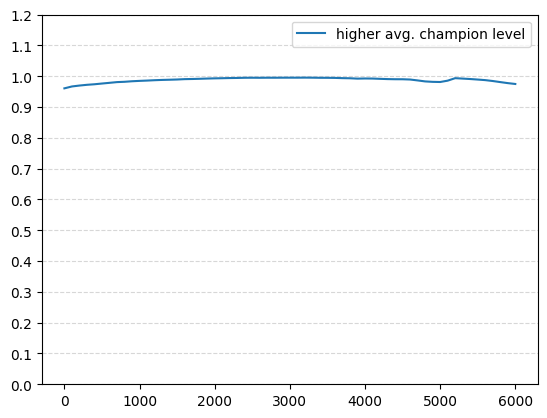

In [12]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [13]:
print(get_percentage_of_surrendered_games(games))

0.2888978116844007
